In [4]:
import json
import pandas as pd
import random
from datasets import load_dataset
from transformers import GPT2LMHeadModel, GPT2Tokenizer, AutoModelForCausalLM, AutoTokenizer
import torch
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence

/ext3/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def load_jsonl(file_path):
    """Load a JSONL file into a DataFrame."""
    data = []
    with open(file_path, 'r', encoding='utf-8') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.DataFrame(data)

In [7]:
def evaluate_priming(model, prime_tokens, good_tokens, bad_tokens, device):
    # This function receives already tokenized and tensorized 'prime_tokens', 'good_tokens', and 'bad_tokens',
    # all of which are expected to be on the specified 'device'.
    
    # Concatenate prime tokens with good and bad tokens for contextual influence
    primed_good_tokens = torch.cat((prime_tokens, good_tokens), dim=1)
    primed_bad_tokens = torch.cat((prime_tokens, bad_tokens), dim=1)

    # Calculate log likelihood for good and bad sentences with priming
    log_likelihood_good = calculate_log_likelihood(model, primed_good_tokens)
    log_likelihood_bad = calculate_log_likelihood(model, primed_bad_tokens)

    # Calculate log likelihood for good and bad sentences without priming (control)
    log_likelihood_good_control = calculate_log_likelihood(model, good_tokens)
    log_likelihood_bad_control = calculate_log_likelihood(model, bad_tokens)

    # Compute the priming effect as the change in likelihood difference due to priming
    delta_original = log_likelihood_good_control - log_likelihood_bad_control
    delta_primed = log_likelihood_good - log_likelihood_bad

    priming_effect = delta_primed - delta_original
    return priming_effect

def calculate_log_likelihood(model, tokens):
    # Assumes that the model has a method to calculate or return the loss when provided with input and labels
    # Here, we use the tokens as both input and labels, typical for language model training and evaluation
    with torch.no_grad():
        outputs = model(tokens, labels=tokens)
        loss = outputs.loss
        log_likelihood = -loss.item()  # Negating the loss to get log likelihood
    return log_likelihood
def evaluate_dataset(model, tokenizer, dataset, prime_sentence, device, batch_size=16):
    if tokenizer.pad_token is None:
        tokenizer.pad_token = tokenizer.eos_token

    prime_tokens = tokenizer.encode(prime_sentence, return_tensors='pt').to(device)

    good_tokens = [tokenizer.encode(data['sentence_good'], return_tensors='pt').squeeze(0) for _, data in dataset.iterrows()]
    bad_tokens = [tokenizer.encode(data['sentence_bad'], return_tensors='pt').squeeze(0) for _, data in dataset.iterrows()]

    good_padded = pad_sequence(good_tokens, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)
    bad_padded = pad_sequence(bad_tokens, batch_first=True, padding_value=tokenizer.pad_token_id).to(device)

    data_loader = DataLoader(TensorDataset(good_padded, bad_padded), batch_size=batch_size, shuffle=False)

    results = []
    for good_batch, bad_batch in data_loader:
        # Repeat prime_tokens to match batch size and concatenate
        repeated_prime_tokens = prime_tokens.repeat(good_batch.size(0), 1)
        effect = evaluate_priming(model, repeated_prime_tokens, good_batch, bad_batch, device)
        results.append(effect)  # Append the float directly

    mean_priming_effect = sum(results) / len(results)
    return mean_priming_effect


def main():
    # Load pre-trained GPT-2 model and tokenizer
    model_name = "gpt2"
    tokenizer = GPT2Tokenizer.from_pretrained(model_name)
    model = GPT2LMHeadModel.from_pretrained(model_name)
    
    # Check if GPU is available and set device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)  # Move model to the device
    
    path = "./sorted_data/"
    prime_sentence = "Let me tell you a wild story."
    results = {}
    
    # Access each file and append the results
    results = {}
    target_dirs = ['sem', 'morp','synsem','syn']  # Directories of interest
    # target_dirs = ['sem', 'morp','syn','synsem']  # Directories of interest
    for root, dirs, files in os.walk(path):
        # Filter directories to only include those we're interested in
        dirs[:] = [d for d in dirs if d in target_dirs]
        for dir in dirs:
            current_path = os.path.join(root, dir)
            results[dir] = []
            print(f"Folder {dir} begins")
            for _, _, files in os.walk(current_path):
                for file in tqdm(files):
                    if 'checkpoint' in file:
                        continue
                    dataset_path = os.path.join(current_path, file)
                    dataset = load_jsonl(dataset_path)
                    result = evaluate_dataset(model, tokenizer, dataset, prime_sentence, device)
                    print(result)
                    results[dir].append(result)
    
    # Load existing results and update them
    if os.path.exists('results.json'):
        with open('results.json', 'r') as f:
            existing_results = json.load(f)
        existing_results.update(results)
        results = existing_results
    
    with open('results.json', 'w') as f:
        json.dump(results, f)

    return results

In [ ]:
if __name__ == "__main__":
    main()

/home/qm351/.local/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Folder syn begins


  4%|▍         | 1/26 [00:31<13:18, 31.95s/it]

-0.034530230930873325


  8%|▊         | 2/26 [01:06<13:27, 33.63s/it]

-0.07305846895490374


In [2]:
# Anova Test: it is significant
with open('results.json', 'r') as f:
    data = json.load(f)

import scipy.stats as stats

# Extracting the values from the dictionary for analysis
groups = [data[key] for key in data]

# Performing the ANOVA test
f_value, p_value = stats.f_oneway(*groups)

print(f"F-Value: {f_value}, P-Value: {p_value}")


F-Value: 4.097649029541424, P-Value: 0.010129250834874877


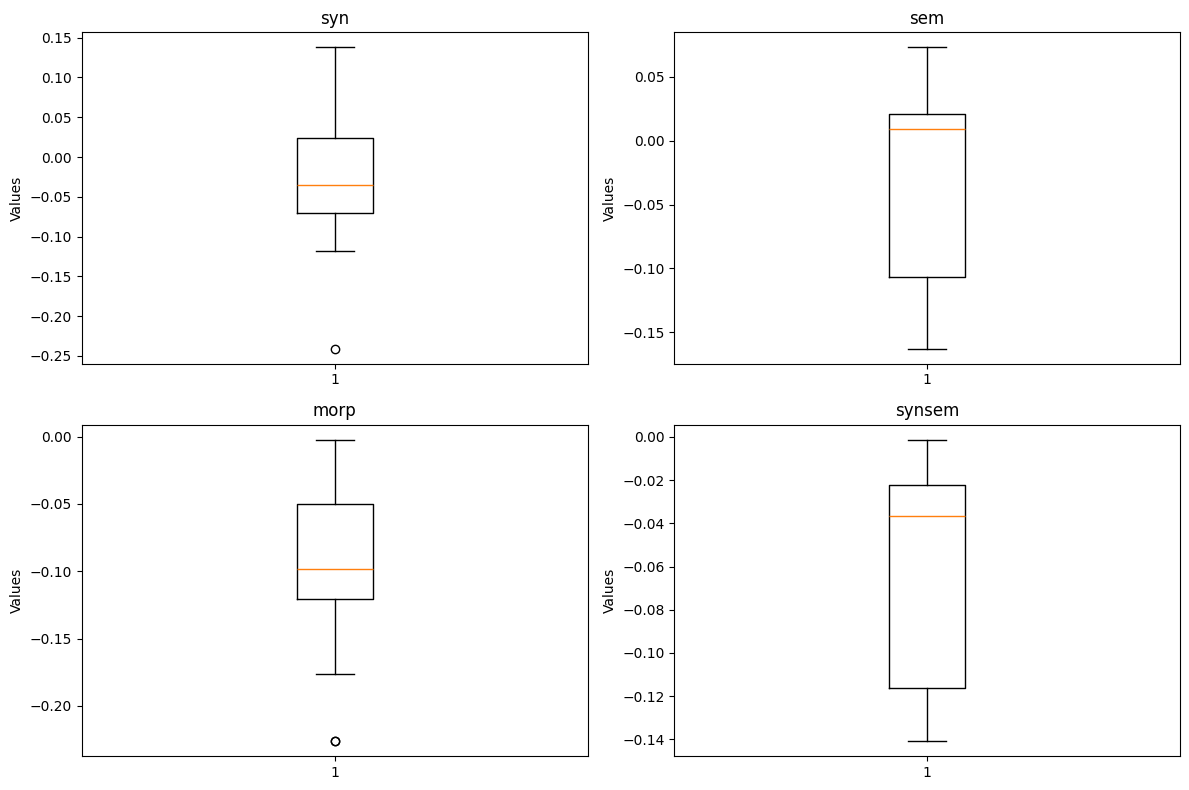

In [5]:
# Create a figure and a set of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))  # Adjust the layout as necessary
axs = axs.flatten()  # Flatten the array of axes to make indexing easier

# Plot each group
for idx, (key, values) in enumerate(data.items()):
    axs[idx].boxplot(values)
    axs[idx].set_title(key)
    axs[idx].set_ylabel('Values')

plt.tight_layout()
plt.show()
